In [19]:
# import stand alone packages
import torch
import importlib
import yaml
import pandas as pd
import numpy as np
import torch.distributions as dist
import matplotlib.pyplot as plt
from rdkit import Chem
import importlib
import selfies
import sys



# import our own functions
sys.path.insert(1, '../model')

import functions
import property_prediction_MLP
import vae


*Pipeline steps:*

*VAE:* 

The first step is to simply train a VAE. Ideal hyperparameters are already set up in the 'selfies_rnn.yml' file. The functions within the VAE are fairly generic, i.e., save models, save scores, etc. The VAE is fed datasets in SMILES form, after which it converts the dataset to SELFIES. There is an option to use SMILES however this is redundant and will be removed in the quality of life stuff.

The VAE saves a model every 50 epochs, you should be able to generate a good model after that many epochs. 


*MLP:*

The settings within the perceptron are slightly more confusing. Since the VAE randomises the input dataset, the alphabets are inconsistent and so we have to specifiy the alphabet of the VAE every time. The MLP has generic functions, similar to the VAE. 


*Analysis:*

Our analysis for QM9 involves looking at the validation dataset and seeing if the perceptron is capable of predicting the HOMO-LUMO gaps. I.e., whether the perceptron can figure out the HOMO-LUMO gaps of data unseen by the VAE. 

Furthermore, in this notebook, all of the non-generic functions will be displayed.

Ultimately, we should have a plot that demonstrates how good the perceptron is at predicting the HOMO-LUMO gaps for unseen molecules. This would be analagous to generating some new latent vectors defined by the latent space. However, since QM9 is complete, we cannot really generate any new molecules, hence the benchmark nature of the paper.


Our analysis uses the QM9 data


In [20]:
# in order to train the RNN vae run
# chemistry_vae_symmetric_rnn_final.main()

In [25]:
# here we want to read in data and tranform them into one_hot
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

smiles_path = "../datasets/QM9/filtered_qm9_energies.csv"

selfies_list, selfies_alphabet, largest_selfies_len = functions.get_selfie_and_smiles_encodings_for_dataset(smiles_path)

--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.


***VAE USAGE:***

In [27]:
###Step 0: Decide what data you want to analyse

# 1. For just one SELFIE:
selfie_input = [selfies_list[0]] ### Choose the SELFIE you want

# 2. For all/multiple SELFIES:

#selfie_input = selfie_list[:1000]


In [28]:
###Step 1: Load the VAE encoder and decoder settings

save_path = './DM_chems/symmetric_rnn_vae_folder/updated_vae2/stack_size1neurons_num2048_l_dim64/'
vae_epoch = 250


vae_settings = yaml.safe_load(open(str(save_path) + "settings/" + "settings.yml", "r"))
encoder_parameter = vae_settings['encoder']
decoder_parameter = vae_settings['decoder']
selfies_alphabet = vae_settings['alphabet']
torch_seed = vae_settings['data']['torch_seed']

In [75]:
###Step 2: Initalise the VAE encoder and decoder

encoder_dict_path = str(save_path) + str(vae_epoch) + "/E.pt"
decoder_dict_path = str(save_path) + str(vae_epoch) + "/D.pt"

encoder_dict = torch.load(encoder_dict_path, map_location = 'cpu')
decoder_dict = torch.load(decoder_dict_path, map_location = 'cpu')


vae_encoder = vae.VAEEncoder(in_dimension=(encoder_dict['encode_RNN.weight_ih_l0'].shape[1]), **encoder_parameter)
vae_decoder = vae.VAEDecoder(**decoder_parameter, out_dimension=len(selfies_alphabet))

vae_encoder.load_state_dict(encoder_dict)
vae_decoder.load_state_dict(decoder_dict)

vae_encoder.eval()
vae_decoder.eval()

VAEDecoder(
  (decode_RNN): GRU(64, 512)
  (decode_FC): Sequential(
    (0): Linear(in_features=512, out_features=27, bias=True)
  )
)

In [86]:
###Optional step: Here we initialise the one hots, this is not necessary to do however it could be informative to look at

### Need to fetch the indices of the rand_perm tensor

data = functions.selfies_to_one_hot(selfies_list, selfies_alphabet, largest_selfies_len)
data = torch.tensor(data, dtype=torch.float).to(device)
torch.manual_seed(torch_seed)
rand_perms = torch.randperm(data.size()[0])
data = data[rand_perms]

### Now we can look at our input selfies:

data = functions.selfies_to_one_hot(selfies_list, selfies_alphabet, largest_selfies_len)
data = torch.tensor(data, dtype=torch.float).to(device)


/users/sgccook2/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/users/sgccook2/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [133]:
largest_molecule_len = int(vae_encoder.encode_RNN.weight_ih_l0.shape[1]/len(selfies_alphabet))
lpoint_size = decoder_dict['decode_RNN.weight_ih_l0'].shape[1]

In [135]:
###Step 4: Generate the latent vectors

mus = functions.selfies_to_lpoints(selfies_list, selfies_alphabet, largest_molecule_len, vae_encoder, lpoint_size)

data.device cpu


In [205]:
###Step 5: Decode the latent vectors (works for a mus tensor containing N number of latent vectors)

# The outputs will all be in SMILES

final_smiles_list = functions.decode_lpoints(mus, selfies_alphabet, vae_decoder, largest_molecule_len)


*Example usage:*

cinnamon

Visual of the chemical itself:


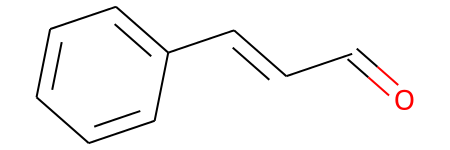

In [206]:
###Step 1: Input your SMILES molecule and convert to a SELFIES

smiles_input = 'C1=CC=C(C=C1)C=CC=O'

selfie_cinnamon = [selfies.encoder(smiles_input)]

molToDraw= Chem.MolFromSmiles(smiles_input)

print('Visual of the chemical itself:')
display(molToDraw)

In [213]:
importlib.reload(functions)

<module 'functions' from './chemDM/model/functions.py'>

In [214]:
###Step 2: Convert the one hot representation to a latent vector:

cinnamon_lpoint  = functions.selfies_to_lpoints(selfie_cinnamon, selfies_alphabet, largest_molecule_len, vae_encoder, lpoint_size)

data.device cpu


In [216]:
###Step 3: Decode the cinnamon latent vector

cinnamon_smiles = functions.decode_lpoints(cinnamon_lpoint, selfies_alphabet, vae_decoder, largest_molecule_len)

In [217]:
print('cinnamon input:', smiles_input, 'cinnamon recreation:', cinnamon_smiles[0])

cinnamon input: C1=CC=C(C=C1)C=CC=O cinnamon recreation: CN1C=C(C=C1)C(N)=O


***MLP:***

In [219]:
# validate perceptron model
mlp_path = './DM_chems/perceptron_folder/qm9_test/'
mlp_epoch = 100

mlp_settings = yaml.safe_load(open(str(mlp_path) + "settings/" + "settings.yml", "r"))
model_params = mlp_settings['model_params']

mlp_model = property_prediction_MLP.PropertyRegressionModel(**model_params).to(device)
state_dict = torch.load(mlp_path + '/' + str(mlp_epoch) + '/model.pt', map_location='cpu')


mlp_model.load_state_dict(state_dict)

<All keys matched successfully>

In [220]:
selfies_input = selfies_list[:10000]

**Plotting the mean relative errors:**

In [221]:
###Step 0: Decide what data you want to analyse

#We will look at the first 10000 molecules

val_int = int(0.8*len(selfies_list))

In [240]:
###Step 1: Prepare the data as we have done in the prior sections


torch_seed = vae_settings['data']['torch_seed']
torch.manual_seed(torch_seed)
rand_perms = torch.randperm(len(selfies_list))
encoding_list = [selfies_list[x] for x in rand_perms]


my_file = pd.read_csv(smiles_path, index_col=None)
properties_tensor = functions.gen_properties_tensor(my_file)
properties_tensor = properties_tensor[rand_perms]


nan_tensor = (properties_tensor.squeeze().isnan() == False).nonzero().squeeze().to(torch.long)
encoding_list = [encoding_list[x] for x in nan_tensor]
properties_tensor = properties_tensor[nan_tensor]

mus = functions.selfies_to_lpoints(encoding_list, selfies_alphabet, largest_molecule_len, vae_encoder, lpoint_size)

train_properties_tensor = properties_tensor[:val_int]
valid_properties_tensor = properties_tensor[val_int:]
mus_train = mus[:val_int]
mus_valid = mus[val_int:]


In [248]:
###Step 2: Take the true HOMO-LUMO gaps and prepare the data


sorted_props, props_index = torch.sort(valid_properties_tensor, dim=0)
mus_ordered = mus_valid[props_index]

In [250]:
###Step 3: Predict the HOMO-LUMO gaps


mlp_model.eval()
with torch.no_grad():
    HL_predictions = mlp_model(mus_ordered.squeeze())

In [259]:
mse, mae, _, r2 = functions.stats(sorted_props,HL_predictions)

print('mse:', mse, 'mae', mae, 'r2', r2)

mse: tensor(0.0001) mae tensor(0.0082) r2 tensor(0.9444)


In [253]:
###Step 5: Prepare the data for plotting

abs_dif = torch.sqrt((sorted_props-HL_predictions)**2)
rel_dif = abs_dif/sorted_props

preds_list = HL_predictions.squeeze().tolist()
sorted_list = sorted_props.squeeze().tolist()
abs_list = abs_dif.squeeze().tolist()
rel_list = rel_dif.squeeze().tolist()

In [254]:

segment_length = len(sorted_list) // 100

homos = [np.mean(sorted_list[i * segment_length: (i + 1) * segment_length]) for i in range(100)]
rels = [np.mean(rel_list[i * segment_length: (i + 1) * segment_length]) for i in range(100)]

bins = 25

seg_length = (max(sorted_list)-min(sorted_list))/bins
props_bins = [min(sorted_props).item()+i*seg_length for i in range(bins)]

/users/sgccook2/.venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/sgccook2/.venv/lib64/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values


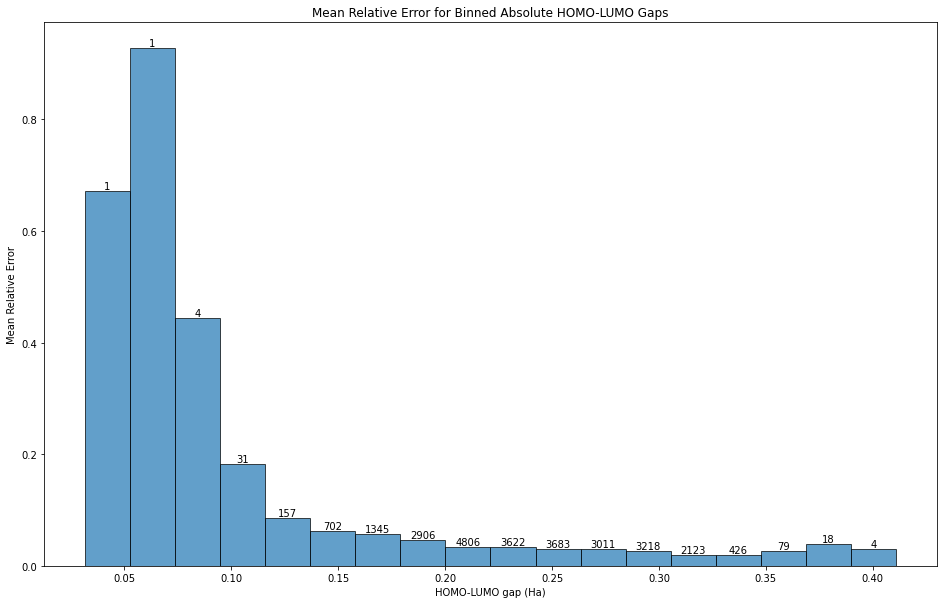

In [256]:
def autolabel(rects, counts):
    for i in range(len(rects)):
        height = rects[i].get_height()
        plt.text(rects[i].get_x() + rects[i].get_width()/2., height , '%d' % int(counts[i]), ha='center', va='bottom')

plt.figure(figsize=(16, 10))

absolute_values = sorted_list[:(len(sorted_list)-1)]
relative_errors = rel_list[:(len(sorted_list)-1)]
bins = np.linspace(min(absolute_values), max(absolute_values), 20)  
digitized = np.digitize(absolute_values, bins)
unique_values, counts = np.unique(digitized, return_counts=True)

mean_relative_errors = [np.mean(np.array(relative_errors)[digitized == i]) for i in range(1, len(bins))]
unique_values, counts = np.unique(digitized, return_counts=True)

# Create the bar plot
bars = plt.bar(bins[:-1], mean_relative_errors, width=np.diff(bins), edgecolor='black', alpha=0.7)

# Call the autolabel function to add labels above each bar
autolabel(bars, counts)

plt.xlabel('HOMO-LUMO gap (Ha)')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error for Binned Absolute HOMO-LUMO Gaps')

# Show the plot
plt.show()

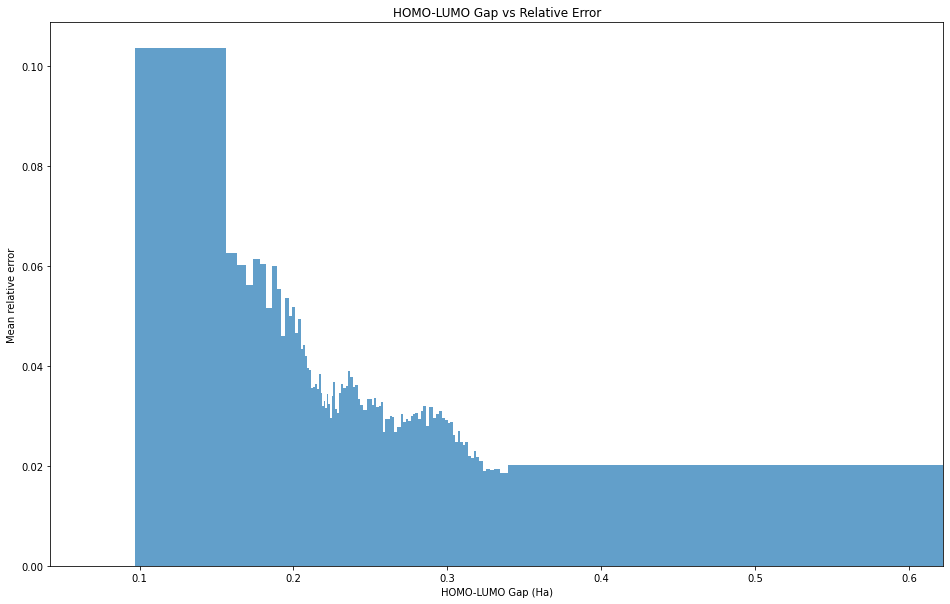

In [257]:
plt.figure(figsize=(16, 10))

homos[0] = homos[0] - min(sorted_list) 
homos[len(homos)-1] = homos[len(homos)-1] + max(sorted_list)
bar_widths = np.diff(np.concatenate([homos, [homos[-1] + (homos[-1] - homos[-2])]]))

plt.bar(homos, rels, width=bar_widths, alpha=0.7, align='edge')
plt.xlabel('HOMO-LUMO Gap (Ha)')
plt.ylabel('Mean relative error')
plt.title('HOMO-LUMO Gap vs Relative Error')
plt.xlim(min(sorted_list), max(sorted_list))
plt.show()


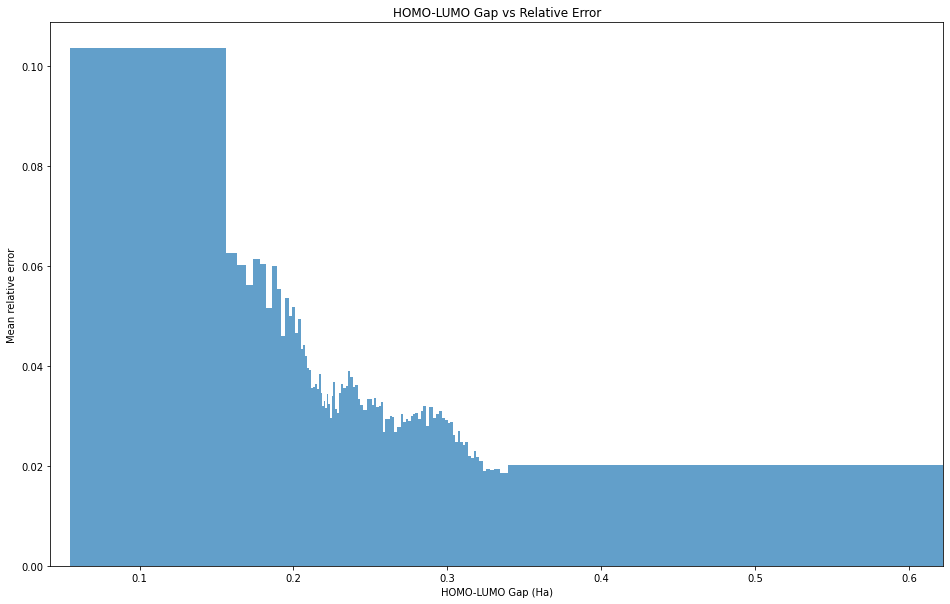

In [258]:
plt.figure(figsize=(16, 10))


# Calculate the width of each bar based on some criteria (replace this with your own logic)
bar_widths = np.diff(np.concatenate([homos, [homos[-1] + (homos[-1] - homos[-2])]]))
homos[0] = homos[0] - min(sorted_list) 
homos[len(homos)-1] = homos[len(homos)-1] + max(sorted_list)
bar_widths[0] = homos[1] - homos[0]

# Plot the bars with variable widths
plt.bar(homos, rels, width=bar_widths, alpha=0.7, align='edge')

# Add labels and title
plt.xlabel('HOMO-LUMO Gap (Ha)')
plt.ylabel('Mean relative error')
plt.title('HOMO-LUMO Gap vs Relative Error')
plt.xlim(min(sorted_list), max(sorted_list))

# Show the plot
plt.show()